### Домашняя работа № 3, Н.В.Кривоногов

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую

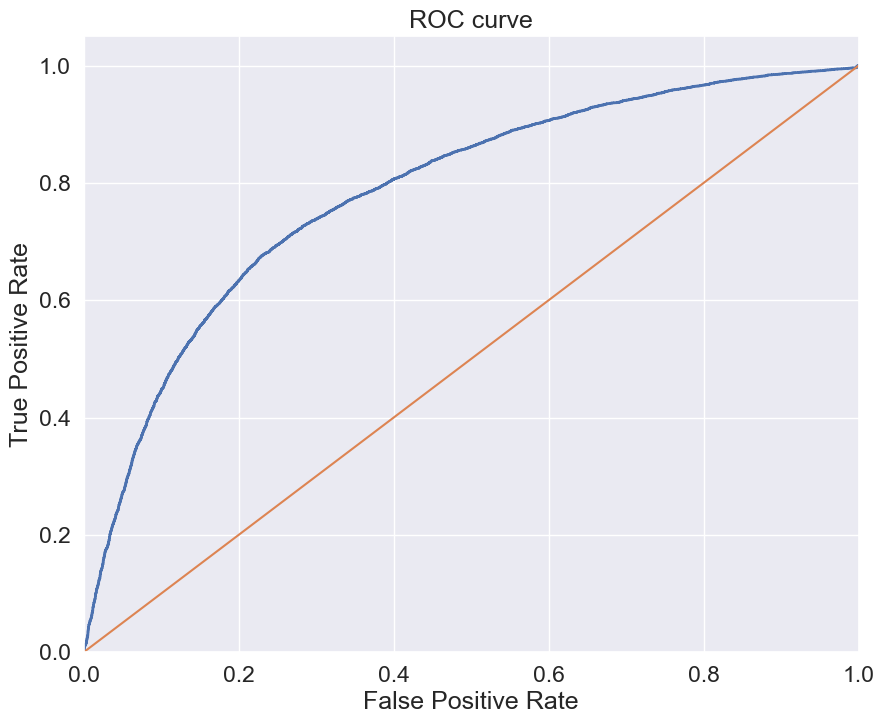

In [8]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230663


Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

#### Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

Логистическая регрессия:

In [10]:
%%time
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Wall time: 683 ms


LogisticRegression()

In [11]:
y_pred_logreg = logreg.predict(X_test)

In [12]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71      8820
           1       0.71      0.66      0.68      8680

    accuracy                           0.70     17500
   macro avg       0.70      0.70      0.70     17500
weighted avg       0.70      0.70      0.70     17500



In [13]:
roc_auc_score_logreg = roc_auc_score(y_test, y_pred_logreg)
roc_auc_score_logreg

0.6990792553580572

In [14]:
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(y_test, y_pred_logreg)
fscore_logreg = (2 * precision_logreg * recall_logreg) / (precision_logreg + recall_logreg)
# locate the index of the largest f score
ix_logreg = np.argmax(fscore_logreg)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_logreg[ix_logreg], 
                                                                        fscore_logreg[ix_logreg],
                                                                        precision_logreg[ix_logreg],
                                                                        recall_logreg[ix_logreg]))

Best Threshold=1.000000, F-Score=0.684, Precision=0.715, Recall=0.655


Градиентный бустинг:

In [15]:
%%time
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

Wall time: 7.97 s


GradientBoostingRegressor()

In [16]:
y_pred_gb = gb_model.predict(X_test)

In [17]:
roc_auc_score_gb = roc_auc_score(y_test, y_pred_gb)
roc_auc_score_gb

0.8021785818782198

In [18]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, y_pred_gb)
fscore_gb = (2 * precision_gb * recall_gb) / (precision_gb + recall_gb)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

Best Threshold=0.374782, F-Score=0.740, Precision=0.682, Recall=0.809


Случайный лес:

In [19]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

Wall time: 10.3 s


RandomForestClassifier()

In [20]:
y_pred_clf = clf.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      8820
           1       0.74      0.69      0.72      8680

    accuracy                           0.73     17500
   macro avg       0.73      0.73      0.73     17500
weighted avg       0.73      0.73      0.73     17500



In [22]:
roc_auc_score_clf = roc_auc_score(y_test, y_pred_clf)
roc_auc_score_clf

0.7258585692341453

In [23]:
precision_clf, recall_clf, thresholds_clf = precision_recall_curve(y_test, y_pred_clf)
fscore_clf = (2 * precision_clf * recall_clf) / (precision_clf + recall_clf)
# locate the index of the largest f score
ix_clf = np.argmax(fscore_clf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_clf[ix_clf], 
                                                                        fscore_clf[ix_clf],
                                                                        precision_clf[ix_clf],
                                                                        recall_clf[ix_clf]))

Best Threshold=1.000000, F-Score=0.715, Precision=0.738, Recall=0.694


#### Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики):

In [24]:
results = {'precision': [precision_logreg[ix_logreg], precision_gb[ix_gb], precision_clf[ix_clf]], 
           'recall': [recall_logreg[ix_logreg], recall_gb[ix_gb], recall_clf[ix_clf]], 
           'auc': [roc_auc_score_logreg, roc_auc_score_gb, roc_auc_score_clf], 
           'f_score': [fscore_logreg[ix_logreg], fscore_gb[ix_gb], fscore_clf[ix_clf]]} 
 
df_results = pd.DataFrame(results, index =['Логистическая регрессия:', 'Градиентный бустинг:', 'Случайный лес:']) 
df_results

,precision,recall,auc,f_score
Логистическая регрессия:,0.714878,0.655415,0.699079,0.683856
Градиентный бустинг:,0.682017,0.808756,0.802179,0.739999
Случайный лес:,0.738203,0.693894,0.725859,0.715363


#### Сделать выводы о том, какая модель справилась с задачей лучше других: 

Модель градиентного бустинга справилась с задачей лучше других: три из четырех метрик оказались выше по показателям. 

В данной задаче наиболее важным показателем является полнота (recall): важно не пропустить ни одного пациента, имеющего заболевание. Как раз она максимальна у градиентного бустинга.